In [1]:
from Data_Input import Input_Data, leaderboard_data
from Data_Processing import Basic_FE
from Data_Splitting import train_test, train_test_val
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#If things aren't working, restart kernel to force it to update imports
#because python is dumb!

In [2]:
# Inputs and processes data
data = Input_Data()
p_data = Basic_FE(data)
#processed_data.info()


In [3]:
#Splits and resamples data
#split = train_test_val(p_data, 0.2,0.1)
split = train_test(p_data, 0.2)
split.resample()

In [19]:
#Fits and tests data

# Basic Idea
Make assumptions (feature engineering, what else..?)
Run models (test assumptions)

In [20]:
# Do different ML systems in separate files
# Make a submission file as well
# Bootstrapping option
# Make ML model class to interface with rest of stuff




#Basic structure:

#X_test Y_test X_train_ Y_train

#import model1 from model1
#import model2 from model2
#
#models = [model1,model2,]
#
# for model in models:
# model1(processed_data) (prints data)

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix

# Create AdaBoostClassifier with DecisionTreeClassifier as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)  # Decision Stump
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)
adaboost.fit(split.trainx, split.trainy, )


# Predict on the test data
y_pred = adaboost.predict(split.testx)

# Calculate the accuracy
accuracy = accuracy_score(split.testy, y_pred)
print(f"Accuracy: {accuracy:.2f}")# Calculate the accuracy
accuracy = accuracy_score(split.testy, y_pred)
# confusion matrix
print(confusion_matrix(split.testy, y_pred > .5))
print(f"Accuracy: {accuracy:.2f}")
print(
    f"Balanced Accuracy: {balanced_accuracy_score(split.testy, y_pred > .5)}"
)

Accuracy: 0.72


In [16]:
from sklearn.ensemble import GradientBoostingClassifier  # For classification tasks
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix

gboost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gboost.fit(split.trainx, split.trainy)

y_pred = gboost.predict(split.testx)

accuracy = accuracy_score(split.testy, y_pred)
print(f"Accuracy: {accuracy:.2f}")# Calculate the accuracy
accuracy = accuracy_score(split.testy, y_pred)
# confusion matrix
print(confusion_matrix(split.testy, y_pred > .5))
print(f"Accuracy: {accuracy:.2f}")
print(
    f"Balanced Accuracy: {balanced_accuracy_score(split.testy, y_pred > .5)}"
)
#150 estimators, depth = 1, LR=0.05: BA = 0.781
#150 estimators, depth = 1, LR=0.03, BA = 0.776
#150 estimators, depth = 1, LR=0.05, BA = 0.78?
#200 estimators, depth = 1, LR=0.05, BA = 0.782
#150 estimators, depth = 2, LR=0.05, BA = 0.779
#120 estimators, depth = 3, LR=0.10, BA = 0.781
#120 estimators, depth = 6, LR=0.10, BA = 0.709
#200 estimators, depth = 3, LR=0.10, BA = 0.785

Accuracy: 0.76
[[28040  8856]
 [   51   220]]
Accuracy: 0.76
Balanced Accuracy: 0.7858910495002609


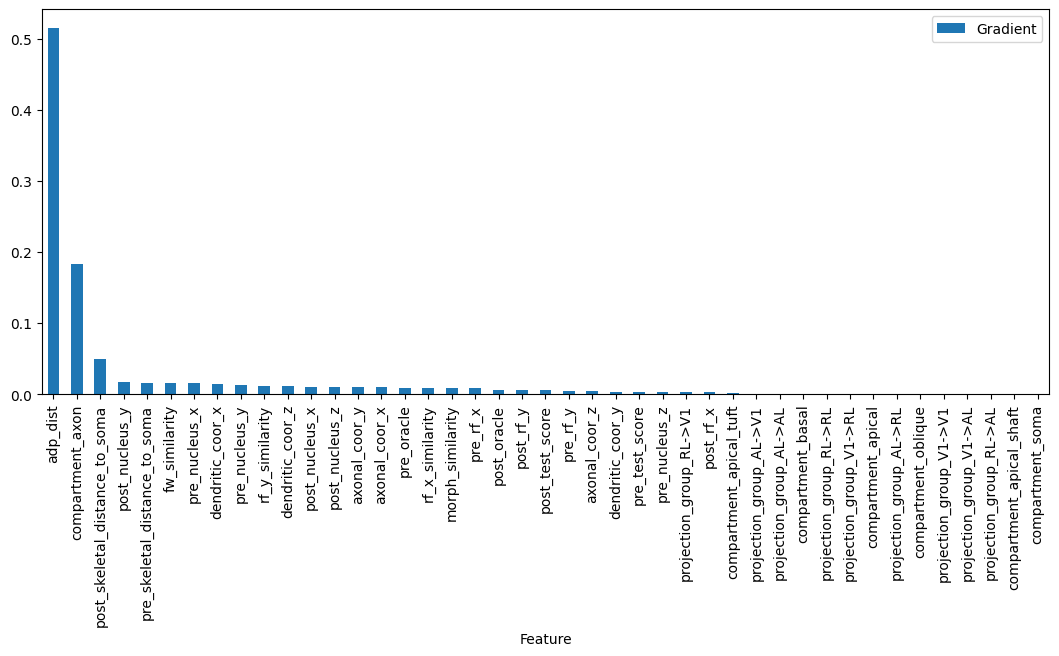

In [17]:
feature_importance = pd.DataFrame({'Feature':split.trainx.columns,'Gradient':gboost.feature_importances_})
feature_importance = feature_importance.set_index('Feature').sort_values(by='Gradient', ascending = False)
feature_importance = feature_importance/feature_importance.sum()
feature_importance.plot.bar(figsize=(13,5))
plt.show()

In [ ]:
#XGBoost
# Try the subsampling, bootstrapping, Hessian

In [19]:
lb_data = leaderboard_data()
#Adjust data

In [20]:
# Submission

IDs = lb_data["ID"]
lb_data = Basic_FE(lb_data)
# oversample connected neuron pairs for full training data

data = Input_Data()
train_data = Basic_FE(data)
train_data = train_test(train_data)
train_data.resample()

# fit model
#adaboost.fit(train_data.trainx, train_data.trainy)
gboost.fit(train_data.trainx, train_data.trainy)

# predict on leaderboard data
#lb_data["pred"] = pipe.predict_proba(lb_data[["fw_similarity", "adp_dist"]])[:, 1]
lb_data["pred"] = gboost.predict(lb_data)
lb_data["ID"]=IDs

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])
submission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42593 entries, 0 to 42592
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         42593 non-null  int64
 1   connected  42593 non-null  bool 
dtypes: bool(1), int64(1)
memory usage: 374.5 KB


In [21]:
#writing csv files
submission_data.to_csv('tbd6.csv',index=False)